[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HongB1/2022-KHU-Bioinformatics-lab/blob/master/code/Lab12_LoR/Lab12_LoR.ipynb)

# Logistic Regression 실습
## Neoantigen roulette 배경지식
#### 1. mutated cancer cell(or tissue)가 signal을 내뿜는 과정
<img src="https://velog.velcdn.com/images/jeguring/post/01937162-d9eb-4d41-b5a6-c16cc8f6a544/image.png" width="30%" height="30%">

1. Mutated cell이 mutated protein을 발현하게 되고,
2. 잘못된 protein은 proteasome에 의해 쪼개져서,
3. 최종적으로 Antigen Presenting Pathway에 의해 세포밖으로 개시가 되는데,
4. 이렇게 개시되는 particle을 우리 몸에 (기존에) 없던 새로운 antigen이라 해서 Neoantigen(신생항원)이라고 부른다.

#### 2. Neoantigen roulette
> Neoantigen roulette : Melanomas with fewer mutation are less likely to contain "winning" neoantigens and are thus more likely to be unresponsive to immunotherapy
Neoantigen roulette의 개념은 이러한 Neoantigen의 수가 많을수록 면역항암치료의 효과가 좋아진다는 개념이다.

<img src="https://velog.velcdn.com/images/jeguring/post/7afb4d2f-8efc-482f-b654-5ed89234d71f/image.png" width="50%" height="50%">

#### 3. 증명 논문
<img src = "https://velog.velcdn.com/images/jeguring/post/f8474891-5003-4fd8-9cd3-0e914cb8e2e3/image.png" width="50%" height="50%">   

위의 Neoantigen roulette의 컨셉이 2014-2015년에 실제 암환자에서 증명이 됨. 
위의 두개의 논문에서는 Neoantigen과 mutation과 예후사이의 관계를 분석하였는데, Neoantigen과 mutation의 수가 많을수록 면역항암제의 효과가 좋았으며, 그에 따른 예후도 좋았음.

## Logistic Regression을 통한 재현 실험

### Data 설명
<img width="616" alt="스크린샷 2022-08-18 오후 6 01 24" src="https://user-images.githubusercontent.com/54663536/185355785-8243aca9-d719-4a7d-aed8-bdc6bbe7bfe5.png">

Ref 10. Roh, W. et al. Integrated molecular analysis of tumor biopsies on sequential CTLA-4 and PD-1 blockade reveals markers of response and resistance. Sci. Transl. Med. 9, eaah3560 (2017).

Ref 21. Van Allen, E. M. et al. Genomic correlates of response to CTLA-4 blockade in metastatic melanoma. Science 350, 207–211 (2015).

Ref 24. Rizvi, N. A. et al. Mutational landscape determines sensitivity to PD-1 blockade in non-small cell lung cancer. Science 348, 124–128 (2015).

Ref 25. Hellmann, M. D. et al. Genomic Features of Response to Combination Immunotherapy in Patients with Advanced Non-Small-Cell Lung Cancer. Cancer Cell 33, 843–852 (2018).


### Data preprocessing

In [1]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import os
os.chdir("/Users/hongb/Dropbox/github/2022_Bioinformatics_lab/code/midterm_data")

In [4]:
ref10 = pd.read_excel('./ref10_3rdSheet.xlsx', sheet_name='Table S2. Sample level info')
ref10.columns

Index(['sample', 'patient', 'time', 'aCTLA4_response', 'aPD1_response',
       'tumor_purity', 'n_nonsynonymous', 'n_neoantigen',
       'n_clones_by_expands', 'n_clones_by_sciclone', 'n_copy_gain',
       'n_copy_loss'],
      dtype='object')

In [5]:
ref10.head()

,sample,patient,time,aCTLA4_response,aPD1_response,tumor_purity,n_nonsynonymous,n_neoantigen,n_clones_by_expands,n_clones_by_sciclone,n_copy_gain,n_copy_loss
0,31A,31,preCTLA4,response,NaN,0.85,819,997,9,2,88.0,0.0
1,34A,34,preCTLA4,nonresponse,response,0.85,3123,5628,17,6,917.0,1129.0
2,50A,50,preCTLA4,nonresponse,nonresponse,0.95,3445,6037,17,2,1008.0,1581.0
3,9A,9,preCTLA4,nonresponse,response,0.85,84,117,5,3,674.0,2400.0
4,5A,5,preCTLA4,response,NaN,0.95,404,296,6,3,0.0,0.0


In [6]:
ref10 = ref10[['sample', 'aPD1_response','n_neoantigen']]
print(len(ref10))
ref10.head()

53


,sample,aPD1_response,n_neoantigen
0,31A,NaN,997
1,34A,response,5628
2,50A,nonresponse,6037
3,9A,response,117
4,5A,NaN,296


In [7]:
# 결측치를 볼 수 있는 세가지 방법 
## 1. df.isnull().sum()
print(ref10.isnull().sum(),'\n'*2)

## 2. df.info()
print(ref10.info())

sample           0
aPD1_response    6
n_neoantigen     0
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sample         53 non-null     object
 1   aPD1_response  47 non-null     object
 2   n_neoantigen   53 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ KB
None


In [8]:
# 결측치 처리 
ref10.dropna(inplace=True)
ref10 = ref10.dropna()
ref10.head()

,sample,aPD1_response,n_neoantigen
1,34A,response,5628
2,50A,nonresponse,6037
3,9A,response,117
5,7A,response,115
6,25A,nonresponse,477


In [9]:
ref10.isnull().sum()

sample           0
aPD1_response    0
n_neoantigen     0
dtype: int64

In [10]:
ref10['answer'] = ref10['aPD1_response'].map(lambda x: 1 if x == 'response' else 0)
ref10.head()

,sample,aPD1_response,n_neoantigen,answer
1,34A,response,5628,1
2,50A,nonresponse,6037,0
3,9A,response,117,1
5,7A,response,115,1
6,25A,nonresponse,477,0


In [11]:
ref24 = pd.read_excel('./ref24_1stSheet.xlsx', skiprows=[0])
ref24

,#,Study ID,"Cohort (Discovery, Validation)",Histology,Age (years),Sex,Smok.^,Pack-years,PD-L1*,Priors^^,Dose (mg/kg),Sched.**,PFS (mos),Event ^^^,Resp ^^^^,Durable Clinical Benefit,Nonsyn.,Smok. Sig. ^^^^^,Neoant.,Total exonic
0,1,SA9755,Valid,NSCLC NOS,63.0,F,Former,36.00,Weak,1.0,10.0,3.0,8.366667,0.0,PR,DCB,1192.0,TH,576.0,1732.0
1,2,HE3202,Disc,Adeno,63.0,F,Former,58.00,Strong,3.0,10.0,3.0,14.666667,0.0,PR,DCB,746.0,TH,610.0,1011.0
2,3,TU0428,Disc,Adeno,66.0,M,Current,48.00,Negative,0.0,10.0,3.0,2.066667,1.0,POD,NDB,626.0,TH,446.0,992.0
3,4,Y2087,Valid,Adeno,68.0,F,Never,0.00,Weak,5.0,10.0,3.0,8.333333,1.0,SD,DCB,507.0,TL,358.0,914.0
4,6,RI1933,Disc,Adeno,60.0,F,Former,21.00,Strong,1.0,10.0,3.0,16.600000,0.0,PR,DCB,473.0,TH,228.0,622.0
5,5,M4945,Valid,Adeno,66.0,M,Former,40.00,Unknown,3.0,10.0,2.0,14.600000,0.0,PR,DCB,427.0,TH,300.0,685.0
6,7,ZA6505,Valid,Adeno,76.0,F,Never,0.00,Negative,6.0,10.0,3.0,1.933333,1.0,POD,NDB,378.0,TL,209.0,558.0
7,8,CU9061,Valid,Squam,57.0,M,Former,39.00,Weak,1.0,2.0,3.0,3.966667,0.0,SD,NR,368.0,TH,271.0,552.0
8,9,CA9903,Disc,Adeno,57.0,M,Former,80.00,Strong,3.0,10.0,3.0,14.500000,1.0,PR,DCB,324.0,TH,226.0,494.0
9,12,KA3947,Disc,Adeno,64.0,F,Former,52.50,Strong,0.0,10.0,3.0,8.133333,1.0,SD,DCB,302.0,TH,114.0,426.0


In [12]:
ref24 = ref24[:34]
ref24.tail()

,#,Study ID,"Cohort (Discovery, Validation)",Histology,Age (years),Sex,Smok.^,Pack-years,PD-L1*,Priors^^,Dose (mg/kg),Sched.**,PFS (mos),Event ^^^,Resp ^^^^,Durable Clinical Benefit,Nonsyn.,Smok. Sig. ^^^^^,Neoant.,Total exonic
29,30,GR0134,Valid,Adeno,80.0,M,Former,56.00,Negative,0.0,10.0,3.0,8.300000,1.0,PR,DCB,56.0,TL,30.0,94.0
30,32,NI9507,Valid,Adeno,41.0,F,Current,2.25,Weak,1.0,10.0,3.0,1.866667,1.0,POD,NDB,35.0,TL,18.0,85.0
31,33,AU5884,Disc,Adeno,64.0,M,Former,10.00,Weak,2.0,10.0,2.0,1.833333,1.0,POD,NDB,34.0,TL,27.0,80.0
32,31,VA1330,Disc,Adeno,71.0,F,Former,0.50,Unknown,1.0,10.0,3.0,4.133333,1.0,SD,NDB,22.0,TL,11.0,88.0
33,34,VA7859,Disc,Adeno,57.0,F,Former,3.15,Unknown,1.0,10.0,3.0,6.266667,1.0,SD,NDB,11.0,TL,8.0,45.0


In [13]:
ref24.columns

Index(['#', 'Study ID', 'Cohort (Discovery, Validation)', 'Histology',
       'Age (years)', 'Sex', 'Smok.^', 'Pack-years', 'PD-L1*', 'Priors^^',
       'Dose (mg/kg)', 'Sched.**', 'PFS (mos)', 'Event ^^^', 'Resp  ^^^^',
       'Durable Clinical Benefit', 'Nonsyn. ', 'Smok. Sig. ^^^^^', 'Neoant. ',
       'Total exonic'],
      dtype='object')

In [14]:
ref24 = ref24[['Study ID', 'PD-L1*', 'Neoant. ']]

In [15]:
ref24['PD-L1*'].unique()

array(['Weak', 'Strong', 'Negative', 'Unknown'], dtype=object)

In [16]:
ref24['PD-L1*'].to_numpy()

array(['Weak', 'Strong', 'Negative', 'Weak', 'Strong', 'Unknown',
       'Negative', 'Weak', 'Strong', 'Strong', 'Weak', 'Weak', 'Strong',
       'Strong', 'Strong', 'Strong', 'Strong', 'Unknown', 'Negative',
       'Weak', 'Negative', 'Negative', 'Weak', 'Weak', 'Strong', 'Weak',
       'Weak', 'Weak', 'Weak', 'Negative', 'Weak', 'Weak', 'Unknown',
       'Unknown'], dtype=object)

In [17]:
answer = []
for i in ref24['PD-L1*'].to_numpy():
    if i == 'Weak': 
        answer.append(1)
    elif i == 'Strong':
        answer.append(1)
    elif i == 'Negative':
        answer.append(0)
    elif i == 'Unknown':
        answer.append(np.nan)

In [18]:
ref24['answer'] = answer
ref24.head()

,Study ID,PD-L1*,Neoant.,answer
0,SA9755,Weak,576.0,1.0
1,HE3202,Strong,610.0,1.0
2,TU0428,Negative,446.0,0.0
3,Y2087,Weak,358.0,1.0
4,RI1933,Strong,228.0,1.0


In [19]:
ref24.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Study ID  34 non-null     object 
 1   PD-L1*    34 non-null     object 
 2   Neoant.   34 non-null     float64
 3   answer    30 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.2+ KB


In [20]:
ref24.dropna(inplace=True) # ref24 = ref24.dropna()

In [21]:
ref25 = pd.read_excel('./ref25_1stSheet.xlsx', skiprows=[0, 1], sheet_name='Table S2')

In [41]:
ref25

,Patient ID,Best Overall Response,Predicted neoantigen burden
0,1,PD,160
1,2,PR,216
2,3,SD,32
3,4,SD,263
4,5,SD,451
...,...,...,...
70,72,PD,9
71,73,PR,2051
72,74,SD,1295
73,43,SD,517


In [42]:
ref25.columns

Index(['Patient ID', 'Best Overall Response', 'Predicted neoantigen burden'], dtype='object')

In [43]:
ref25 = ref25[['Patient ID', 'Best Overall Response', 'Predicted neoantigen burden']]

In [44]:
ref25['Best Overall Response'].unique()

array(['PD', 'PR', 'SD', 'NE', 'CR'], dtype=object)

In [45]:
ref25['answer'] = ref25['Best Overall Response'].map(lambda x: 1 if x.endswith('R') else 0)
ref25.head()

,Patient ID,Best Overall Response,Predicted neoantigen burden,answer
0,1,PD,160,0
1,2,PR,216,1
2,3,SD,32,0
3,4,SD,263,0
4,5,SD,451,0


In [46]:
ref21 = pd.read_excel('./ref21_2ndSheet.xlsx', sheet_name = 'exome analysis (n=110)')
ref21.head()

/Users/hongb/opt/miniconda3/envs/bioinforlab/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,patient,age_start,gct,RECIST,overall_survival,progression_free,primary,group,histology,stage,...,snps,mutations,mtc_tumor,mtc_normal,hla.a1,hla.a2,hla.b1,hla.b2,hla.c1,hla.c2
0,Pat02,42,1,SD,1632,538,occult,response,Unknown or NA,Stage 4,...,332,378,125.846615,34.933691,HLA-A02:01,HLA-A26:01,HLA-B08:01,HLA-B07:02,HLA-C07:02,HLA-C07:02
1,Pat03,61,1,PD,100,76,skin,nonresponse,Acrolentigenous,Stage 4,...,590,602,228.711135,158.387861,HLA-A03:01,HLA-A29:01,HLA-B07:05,HLA-B35:01,HLA-C15:05,HLA-C04:01
2,Pat04,71,1,PR,987,646,skin,response,Nodular,Stage 4,...,509,527,228.137869,182.495884,HLA-A01:01,HLA-A02:01,HLA-B15:01,HLA-B44:05,HLA-C02:02,HLA-C03:03
3,Pat06,33,1,PD,161,77,skin,nonresponse,Superficial spreading,Stage 4,...,232,295,156.646653,26.102230,HLA-A11:01,HLA-A02:01,HLA-B27:02,HLA-B55:01,HLA-C03:03,HLA-C02:02
4,Pat07,36,0,SD,1050,721,skin,response,Unknown or NA,Stage 3,...,224,235,216.280881,133.963184,HLA-A01:01,HLA-A01:01,HLA-B07:02,HLA-B08:01,HLA-C07:02,HLA-C07:01


In [47]:
ref21.columns

Index(['patient', 'age_start', 'gct', 'RECIST', 'overall_survival',
       'progression_free', 'primary', 'group', 'histology', 'stage', 'M',
       'gender', 'date_birth', 'LDH', 'pre_therapies', 'pre_BRAF', 'post_BRAF',
       'therapy_start', 'therapy_end', 'date_death', 'dead',
       'date_progression', 'progression', 'neos500', 'neos250', 'neos100',
       'neos50', 'synonymous', 'nonsynonymous', 'indels', 'snps', 'mutations',
       'mtc_tumor', 'mtc_normal', 'hla.a1', 'hla.a2', 'hla.b1', 'hla.b2',
       'hla.c1', 'hla.c2'],
      dtype='object')

In [48]:
ref21 = ref21[['patient', 'group', 'neos500']]

In [49]:
ref21['group'].unique()

array(['response', 'nonresponse', 'long-survival'], dtype=object)

In [50]:
ref21 = ref21[~ref21['group'].str.contains('long')] # group 컬럼에서 'long'이란 문자열 포함한 것 제거
# ref21 = ref21[~ref21['group'].isin(['long-survival'])]

In [51]:
ref21['answer'] = ref21['group'].map(lambda x: 1 if x == 'response' else 0)

In [52]:
ref21

,patient,group,neos500,answer
0,Pat02,response,244,1
1,Pat03,nonresponse,475,0
2,Pat04,response,568,1
3,Pat06,nonresponse,382,0
4,Pat07,response,147,1
...,...,...,...,...
105,Pat86,nonresponse,111,0
106,Pat88,response,2285,1
107,Pat90,response,330,1
108,Pat92,nonresponse,21,0


In [53]:
ref21.head()

,patient,group,neos500,answer
0,Pat02,response,244,1
1,Pat03,nonresponse,475,0
2,Pat04,response,568,1
3,Pat06,nonresponse,382,0
4,Pat07,response,147,1


In [54]:
ref10.head()

,sample,pd1_response,neoantigen_burden,answer
1,34A,response,5628,1
2,50A,nonresponse,6037,0
3,9A,response,117,1
5,7A,response,115,1
6,25A,nonresponse,477,0


In [55]:
ref25.head()

,Patient ID,Best Overall Response,Predicted neoantigen burden,answer
0,1,PD,160,0
1,2,PR,216,1
2,3,SD,32,0
3,4,SD,263,0
4,5,SD,451,0


In [56]:
ref24.head()

,Study ID,PD-L1*,Neoant.,answer
0,SA9755,Weak,576.0,1.0
1,HE3202,Strong,610.0,1.0
2,TU0428,Negative,446.0,0.0
3,Y2087,Weak,358.0,1.0
4,RI1933,Strong,228.0,1.0


In [57]:
ref21

,patient,group,neos500,answer
0,Pat02,response,244,1
1,Pat03,nonresponse,475,0
2,Pat04,response,568,1
3,Pat06,nonresponse,382,0
4,Pat07,response,147,1
...,...,...,...,...
105,Pat86,nonresponse,111,0
106,Pat88,response,2285,1
107,Pat90,response,330,1
108,Pat92,nonresponse,21,0


In [58]:
ref25.columns

Index(['Patient ID', 'Best Overall Response', 'Predicted neoantigen burden',
       'answer'],
      dtype='object')

In [59]:
ref21.columns = ['sample', 'pd1_response','neoantigen_burden','answer']
ref10.columns = ['sample', 'pd1_response','neoantigen_burden','answer']
ref25.columns = ['sample', 'pd1_response','neoantigen_burden','answer']
ref24.columns = ['sample', 'pd1_response','neoantigen_burden','answer']

In [60]:
lung = pd.concat([ref25, ref24], axis = 0)
melanoma = pd.concat([ref21, ref10], axis = 0)

In [61]:
lung

,sample,pd1_response,neoantigen_burden,answer
0,1,PD,160.0,0.0
1,2,PR,216.0,1.0
2,3,SD,32.0,0.0
3,4,SD,263.0,0.0
4,5,SD,451.0,0.0
...,...,...,...,...
27,RO3338,Weak,112.0,1.0
28,LO5004,Weak,87.0,1.0
29,GR0134,Negative,30.0,0.0
30,NI9507,Weak,18.0,1.0


/Users/hongb/opt/miniconda3/envs/bioinforlab/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


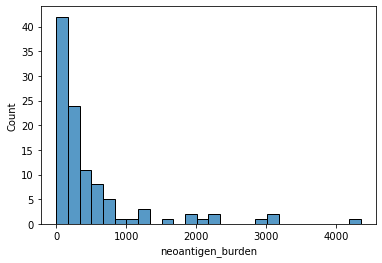

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(lung['neoantigen_burden'])
plt.show()
plt.close()

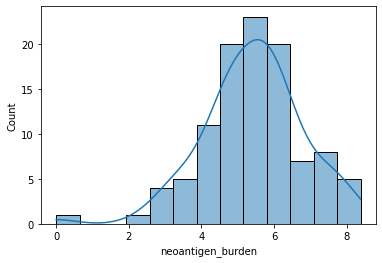

In [63]:
log_neoantigen_burden = np.log1p(lung['neoantigen_burden'])
sns.histplot(log_neoantigen_burden, kde=True)
plt.show()
plt.close()

In [64]:
lung['log_neoantigen_burden'] = log_neoantigen_burden
lung.head()

,sample,pd1_response,neoantigen_burden,answer,log_neoantigen_burden
0,1,PD,160.0,0.0,5.081404
1,2,PR,216.0,1.0,5.379897
2,3,SD,32.0,0.0,3.496508
3,4,SD,263.0,0.0,5.575949
4,5,SD,451.0,0.0,6.113682


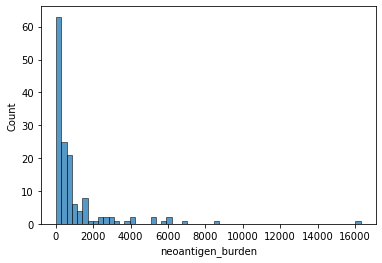

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(melanoma['neoantigen_burden'])
plt.show()
plt.close()

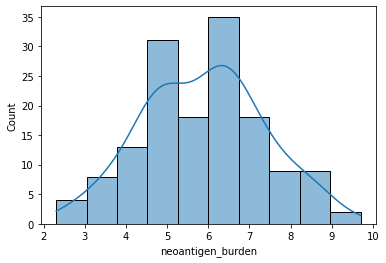

In [66]:
log_neoantigen_burden = np.log1p(melanoma['neoantigen_burden'])
sns.histplot(log_neoantigen_burden, kde=True)
plt.show()
plt.close()

In [67]:
melanoma['log_neoantigen_burden'] = log_neoantigen_burden
melanoma.head()

,sample,pd1_response,neoantigen_burden,answer,log_neoantigen_burden
0,Pat02,response,244,1,5.501258
1,Pat03,nonresponse,475,0,6.165418
2,Pat04,response,568,1,6.343880
3,Pat06,nonresponse,382,0,5.948035
4,Pat07,response,147,1,4.997212


In [2]:
# lung.to_pickle("LR_lung_dataset.pkl")
# melanoma.to_pickle("LR_melanoma_dataset.pkl")
import pandas as pd
import numpy as np
lung = pd.read_pickle("LR_lung_dataset.pkl")
melanoma = pd.read_pickle("LR_melanoma_dataset.pkl")

# Train Logistic regression 

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## lung

In [165]:
X_features = np.array(lung['log_neoantigen_burden']).reshape(-1, 1)
y_target = lung['answer']

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.1, random_state=22122)

In [166]:
# 로지스틱 회귀를 이용하여 학습 및 예측 수행. 
from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf = LogisticRegression() 

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# sklearn.model_selection.GridSearchCV(estimator(모델), param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
grid_values = {
              'penalty': ['l1','l2', 'elasticnet', None],
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              }


model_lr = GridSearchCV(lr_clf, param_grid=grid_values)
model_lr.fit(X_train, y_train)

/opt/anaconda3/envs/lab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/lab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/lab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/lab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/lab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/envs/lab/lib/python3.10/site-packages/sklearn

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [167]:
model_lr.score(X_test, y_test)

0.7272727272727273

GridSearchCV 클래스의 생성자 정리

- estimator : classifier, regressor, pipeline 등 가능

- param_grid : 튜닝을 위해 파라미터, 사용될 파라미터를 dictionary 형태로 만들어서 넣는다.
  - 주요 하이퍼 파라미터 : penalty, C, solver
  - Penalty : 규제 유형을 설정하며 ‘l2’로 설정 시 L2 규제를, ‘l1’으로 설정 시 L1 규제를 뜻합니다.
  - C는 규제 강도를 조절하는 alpha값의 역수. C = 1/alpha, C값이 작을 수록 규제 강도가 큼
  - solver는 회귀 계수 최적화를 위한 다양한 최적화 방식
    - lbfgs
    - liblinear
    - newton-cg
    - sag
    - saga

- scoring : 예측 성능을 측정할 평가 방법을 넣는다. 보통 accuracy 로 지정하여서 정확도로 성능 평가를 한다.

- cv : 교차 검증에서 몇개로 분할되는지 지정한다.

- refit : True가 디폴트로 True로 하면 최적의 하이퍼 파라미터를 찾아서 재학습 시킨다.

https://dacon.io/codeshare/4646

```python
sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)[source]
```
Exhaustive search over specified parameter values for an estimator.

Important members are fit, predict.
GridSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

### Parameters
- estimator: `estimator object(model)`
  - This is assumed to implement the scikit-learn estimator interface. Either estimator needs to provide a score function, or scoring must be passed.
- param_grid: `dict or list of dictionaries`
  - Dictionary with parameters names (str) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. This enables searching over any sequence of parameter settings.
- scoring: `str, callable, list, tuple or dict, default=None`
  - Strategy to evaluate the performance of the cross-validated model on the test set.
- cv: `int, cross-validation generator or an iterable, default=None`
  - Determines the cross-validation splitting strategy.

In [168]:


# # GridSearchCV의 param_grid 설정
# params = {
#               'penalty': ['l1','l2', 'elasticnet', None],
#               'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#               'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
#                }

# lr_clf = LogisticRegression()
# grid_clf = GridSearchCV(lr_clf, param_grid=params, n_jobs=-1, cv=3)
# grid_clf.fit(X_train, y_train)

# # ConvergenceWarning: The max_iter was reached which means the coef_ did not converge: converge가 되면 수렴값ㅡㄹ 

In [169]:
# grid_clf.score(X_test, y_test)

In [170]:
pd.DataFrame(model_lr.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000200,0.000137,0.000000,0.000000,l1,newton-cg,"{'penalty': 'l1', 'solver': 'newton-cg'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
1,0.000133,0.000067,0.000000,0.000000,l1,lbfgs,"{'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,18
2,0.000504,0.000119,0.000218,0.000026,l1,liblinear,"{'penalty': 'l1', 'solver': 'liblinear'}",0.526316,0.526316,0.315789,0.578947,0.555556,0.500585,0.094484,7
3,0.000090,0.000006,0.000000,0.000000,l1,sag,"{'penalty': 'l1', 'solver': 'sag'}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
4,0.001277,0.000202,0.000303,0.000067,l1,saga,"{'penalty': 'l1', 'solver': 'saga'}",0.578947,0.526316,0.263158,0.631579,0.611111,0.522222,0.134320,6


In [171]:
# best_estimator_estimator
# Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data. 
model_lr.best_estimator_

LogisticRegression(solver='saga')

In [172]:
print(f'최적 하이퍼 파라미터:{model_lr.best_params_}\n최적 평균 정확도:{model_lr.best_score_:^.3f}')

최적 하이퍼 파라미터:{'penalty': 'l2', 'solver': 'saga'}
최적 평균 정확도:0.543


### Confusion Matrix

In [173]:
from sklearn.metrics import confusion_matrix

pred = model_lr.predict(X_test)
confusion_matrix(y_test, pred)

array([[6, 0],
       [3, 2]])

In [103]:
print(confusion_matrix.__doc__)

Compute confusion matrix to evaluate the accuracy of a classification.

    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` and
    predicted to be in group :math:`j`.

    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

    Read more in the :ref:`User Guide <confusion_matrix>`.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.

    y_pred : array-like of shape (n_samples,)
        Estimated targets as returned by a classifier.

    labels : array-like of shape (n_classes), default=None
        List of labels to index the matrix. This may be used to reorder
        or select a subset of labels.
        If ``None`` is given, those that appear at least once
        in ``y

In [174]:
np.bincount(y_train)

array([51, 43])

/opt/anaconda3/envs/lab/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


,precision,recall,f1-score,support
0.0,0.666667,1.000000,0.800000,6.000000
1.0,1.000000,0.400000,0.571429,5.000000
accuracy,0.727273,0.727273,0.727273,0.727273
macro avg,0.833333,0.700000,0.685714,11.000000
weighted avg,0.818182,0.727273,0.696104,11.000000


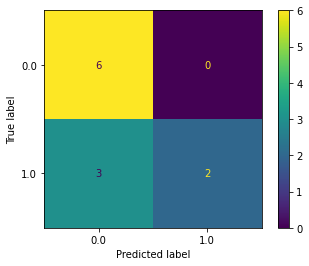

In [175]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
# sklearn.metrics.classification_report(y_true, y_pred)
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

best_predict = model_lr.best_estimator_.predict(X_test)
plot_confusion_matrix(model_lr, X_test, y_test)
report = classification_report(y_test, best_predict, output_dict=True)
pd.DataFrame(report).transpose()

# print(classification_report(y_test, best_predict))
# print("\nGrid Search : ", accuracy_score(y_test, best_predict))

In [210]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출 
pred_proba_class1 = model_lr.predict_proba(X_test)[:, 1] 
fprs , tprs , thresholds = roc_curve(y_test, pred_proba_class1)

# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
# 임계값에 따른 FPR, TPR 값
print('임계값: ', thresholds[1:])
print('임곗값별 FPR: ', np.round(fprs, 3))
print('임곗값별 TPR: ', np.round(tprs, 3))

임계값:  [0.60914315 0.50637188 0.48805657 0.48182284 0.42523503 0.33601264]
임곗값별 FPR:  [0.    0.    0.    0.333 0.333 1.    1.   ]
임곗값별 TPR:  [0.  0.2 0.4 0.4 0.6 0.6 1. ]


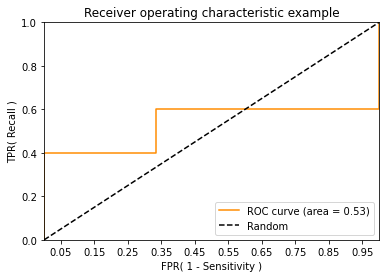

In [219]:
from sklearn.metrics import roc_curve, auc

def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test , pred_proba_c1)
    roc_auc = auc(fprs, tprs)
    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, color='darkorange',
            label=f'ROC curve (area = {roc_auc:.2f})')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
roc_curve_plot(y_test, model_lr.predict_proba(X_test)[:, 1] )

/opt/anaconda3/envs/lab/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


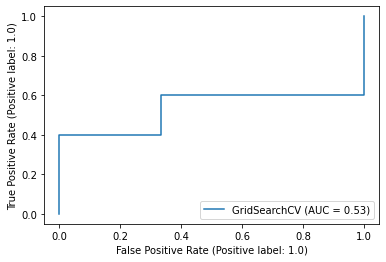

In [221]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model_lr, X_test, y_test)

In [126]:
import optuna
import sklearn
import sklearn.datasets
import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

def objectiveLR(trial: Trial, X, y, test):
    param = {
                "random_state" : 42,
            'penalty': trial.suggest_categorical("penalty", ['l2']),
            'solver': trial.suggest_categorical("solver", ['newton-cg', 'lbfgs', 'sag', 'saga']),
            'C': trial.suggest_loguniform("C", 0.001, 1000)
    }

    model = LogisticRegression(**param)
    LR_model = model.fit(X, y)

    score = cross_val_score(LR_model, X, y, cv=3, scoring='roc_auc')

    return score

In [127]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())

study.optimize(lambda trial : objectiveLR(trial, X_train, y_train, X_test), n_trials=10)
print('Best tiral: score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-08-19 05:06:03,882] A new study created in memory with name: no-name-215760ce-f5e8-4cc8-a4d9-af106d6c1c81
/Users/hongb/opt/miniconda3/envs/bioinforlab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongb/opt/miniconda3/envs/bioinforlab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongb/opt/miniconda3/envs/bioinforlab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hongb/opt/miniconda3/envs/bioinforlab/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[W 2022-08-19 05:06:03,923] Trial 0 failed, becaus

ValueError: No trials are completed yet.

In [119]:
study.predict(X_test)

AttributeError: 'Study' object has no attribute 'predict'

In [123]:
optuna.visualization.plot_param_importances(study)

optuna.visualization.plot_optimization_history(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

## Homework : melanoma set에 대해 분석

In [66]:
melanoma.columns

Index(['sample', 'pd1_response', 'neoantigen_burden', 'answer',
       'log_neoantigen_burden'],
      dtype='object')

In [67]:
xTrain, xTest, yTrain, yTest = train_test_split(np.array(melanoma['log_neoantigen_burden']).reshape(-1,1), melanoma['answer'], test_size = 0.1)

In [ ]:
grid_values = {'penalty': ['l1','l2', 'elasticnet', None],
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'cv':[2,3,4,5,6]}
lr = LogisticRegressionCV()
model_lr = GridSearchCV(lr, param_grid=grid_values)

In [ ]:
model_lr.fit(xTrain, yTrain)
model_lr.score(xTest, yTest)

In [ ]:
from sklearn.metrics import confusion_matrix

pred = model_lr.predict(xTest)
confusion_matrix(yTest, pred)

In [ ]:
plot_confusion_matrix(model_lr, xTest, yTest) 

In [ ]:
plot_roc_curve(model_lr, xTest, yTest)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(yTest, pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yTest.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [ ]:
print(data.DESCR)

In [ ]:
pd.DataFrame(data.data, columns = data.feature_names)

In [ ]:
import sklearn

sklearn.__version__